In [1]:
import autograd.numpy as np
import numpy as pure_np
import autograd
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import pyamg

## Generate matrix with PyAMG and compute spectral radius with the default parameters

In [2]:
n = 127
k = 0
num_levels = 4
A = pyamg.gallery.poisson((n, n), format='csr')
A = A - k**2 * spsp.eye(A.shape[0]) / (n+1)**2

ml = pyamg.ruge_stuben_solver(A, CF="RS", max_levels=num_levels, 
                             presmoother=('jacobi', {'omega': 2.0/3.0, 'iterations': 2, "withrho": False}),
                             postsmoother=('jacobi', {'omega': 2.0/3.0, 'iterations' : 2, "withrho": False})
                             )


print(ml)
num_levels = len(ml.levels)

multilevel_solver
Number of Levels:     4
Operator Complexity:  2.173
Grid Complexity:      1.657
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0        16129        80137 [46.02%]
    1         8065        71569 [41.10%]
    2         2027        17891 [10.27%]
    3          503         4541 [ 2.61%]



In [3]:
x0 = np.zeros((A.shape[0], 1))
x_range = np.linspace(0, 1, num=n+2)
x_range = x_range[1:-1]
# rhs = np.pi**2 * np.sin(np.pi * x_range) / (n+1)**2
x_range, y_range = np.meshgrid(x_range, x_range)
x_true = np.sin(np.pi * x_range) * np.sin(np.pi * y_range)
rhs = (2 * np.pi**2 * x_true - k**2 * x_true) / (n+1)**2
rhs = rhs.reshape(A.shape[0], 1)
rhs.shape

(16129, 1)

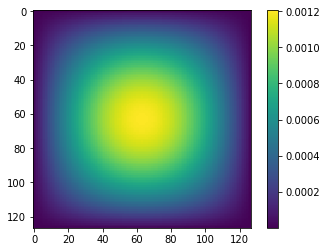

In [4]:
plt.imshow(rhs.reshape(n, n))
plt.colorbar()

In [5]:
x = ml.solve(rhs, tol=1e-10)
x = x[:, np.newaxis]

In [6]:
print("Residual norm = {}".format(np.linalg.norm(rhs-A.dot(x))))
print("Error = {}".format(np.linalg.norm(x_true - x.reshape(n, n))))

Residual norm = 4.9027719148485936e-12
Error = 0.003212858575302263


In [7]:
for l in ml.levels[:-1]:
    print(l.R.shape, l.A.shape, l.P.shape)
ml.levels[-1].A.shape

(8065, 16129) (16129, 16129) (16129, 8065)
(2027, 8065) (8065, 8065) (8065, 2027)
(503, 2027) (2027, 2027) (2027, 503)


(503, 503)

In [8]:
def compute_spectral_radius_pyamg(pyamg_solver):
    n = pyamg_solver.levels[0].A.shape[0]
    M = spsplin.LinearOperator((n, n), 
                               matvec=lambda x: pyamg_solver.solve(np.zeros((n, 1)), x0=x, maxiter=1))
    rho = spsplin.eigs(M, k=1, return_eigenvectors=False, which="LM")[0]
    return abs(rho)

In [9]:
pyamg_rho = compute_spectral_radius_pyamg(ml)
print("Spectral radius for default parameters = {}".format(pyamg_rho))

Spectral radius for default parameters = 0.26354464738686495


## Custom implementation of V-cycle

In [10]:
import csr_compatible_primitives as csr_prim

In [11]:
def jacobi_smooth_sparse(A_values, A_indices, A_indptr, x0, b, w):
    x = x0
    n = x.shape[0]
    d = csr_prim.get_sparse_diag(A_values, A_indices, A_indptr, n)
    for i in range(2):
        Ax = csr_prim.csr_matvec(A_values, A_indptr, A_indices, x)
        x = x - w * (Ax - b) / d
    return x

In [12]:
def V_cycle(x0, b, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level=1, w=2.0/3.0):
    x = x0
    if level == 0:
        A_full = csr_prim.csr2dense(A_values[level], A_coarse_indices, A_coarse_indptr, A_coarse_indptr.shape[0] - 1)
        x = np.linalg.solve(A_full, b)
    else:
        x = jacobi_smooth_sparse(A_values[level], A_indices[level], A_indptr[level], x, b, w)
        Ax = csr_prim.csr_matvec(A_values[level], A_indptr[level], A_indices[level], x)
        res = b - Ax
        proj_res = csr_prim.csr_matvec(R_values[level], R_indptr[level], R_indices[level], res)
        e = np.zeros_like(proj_res)
        u = V_cycle(e, proj_res, A_values[:-1], A_indptr[:-1], A_indices[:-1],
                    P_values[:-1], P_indptr[:-1], P_indices[:-1], 
                    R_values[:-1], R_indptr[:-1], R_indices[:-1], 
                    level-1, w)
        Pu = csr_prim.csr_matvec(P_values[level], P_indptr[level], P_indices[level], u)
        x = x + Pu
        x = jacobi_smooth_sparse(A_values[level], A_indices[level], A_indptr[level], x, b, w)
    return x

In [13]:
A_list = [l.A.sorted_indices() for l in ml.levels]
P_list = [l.P.sorted_indices() for l in ml.levels[:-1]]
R_list = [l.R.sorted_indices() for l in ml.levels[:-1]]

In [14]:
A_values = [A.data for A in A_list[::-1]]
A_indices = [A.indices for A in A_list[::-1]]
A_indptr = [A.indptr for A in A_list[::-1]]
A_coarse_indices = A_indices[0]
A_coarse_indptr = A_indptr[0]

In [15]:
P_values = [[]] + [P.data for P in P_list[::-1]]
P_indices = [[]] + [P.indices for P in P_list[::-1]]
P_indptr = [[]] + [P.indptr for P in P_list[::-1]]

In [16]:
R_values = [[]] + [R.data for R in R_list[::-1]]
R_indices = [[]] + [R.indices for R in R_list[::-1]]
R_indptr = [[]] + [R.indptr for R in R_list[::-1]]

In [17]:
x = np.zeros((A.shape[0], 1))
for i in range(10):
    x = V_cycle(x, rhs, A_values, A_indptr, A_indices, 
                       P_values, P_indptr, P_indices,
                       R_values, R_indptr, R_indices,
                       level=num_levels-1, w=2.0/3.0)
    print(np.linalg.norm(A.dot(x) - rhs))

0.017948217531773846
0.0031663446106539933
0.0007359573459693614
0.00018721547703185286
4.858495430708448e-05
1.2656223431103304e-05
3.300305070209172e-06
8.610834776631662e-07
2.247647197290729e-07
5.869222296280214e-08


### Compare spectral radius with PyAMG

In [18]:
def generate_all_A(A_csr_value, A_csr_indices, A_csr_indptr, 
                   P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   RAP_list_indices, RAP_list_indptr, level=1):
    
    A_values = [[] for i in range(level+1)]
    A_indices = RAP_list_indices + [A_csr_indices]
    A_indptr = RAP_list_indptr + [A_csr_indptr]
    A_values[level] = A_csr_value
#     A_indices[level] = A_csr_indices
#     A_indptr[level] = A_csr_indptr
    
    for l in range(level-1, -1, -1):
        n = A_indptr[l+1].shape[0] - 1
        n_coarse = R_indptr[l+1].shape[0] - 1
        A_values[l], _, _ = csr_prim.csr_3mat(R_values[l+1], R_indptr[l+1], R_indices[l+1], 
                                     A_values[l+1], A_indptr[l+1], A_indices[l+1], 
                                     P_values[l+1], P_indptr[l+1], P_indices[l+1], 
                                     n_coarse, n, n, n_coarse)
    return A_values, A_indices, A_indptr

def multigrid_matvec(x, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w):
    
    rhs = np.zeros((A_indptr[-1].shape[0] - 1, 1))
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    y = V_cycle(x, rhs, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w)
    return y

def compute_spectral_radius_multigrid(A, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w):
    A_values, A_indices_, A_indptr_ = generate_all_A(A.data, A.indices, A.indptr, P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   A_indices, A_indptr, level)
    M = spsplin.LinearOperator((A_indptr_[-1].shape[0] - 1, A_indptr_[-1].shape[0] - 1), 
                               matvec=lambda x: multigrid_matvec(x, A_values, A_indptr_, A_indices_, 
                                               P_values, P_indptr, P_indices,
                                               R_values, R_indptr, R_indices,
                                               level, w))
    rho = spsplin.eigs(M, k=1, return_eigenvectors=False, which="LM")[0]
    return abs(rho)

In [19]:
compute_spectral_radius_multigrid(A, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level=num_levels-1, w=2./3)

0.26354464738686445

## Define all for optimization

In [20]:
def v_cycle_objective(R_values_active, P_values_active, w, x, num_levels):
    K = 10
    rhs = np.zeros((A.shape[0], num_trials))
    P_values = [[]] + P_values_active
    R_values = [[]] + R_values_active
    A_values, A_indices_, A_indptr_ = generate_all_A(A.data, A.indices, A.indptr, 
                                                   P_values, P_indices, P_indptr, 
                                                   R_values, R_indices, R_indptr,
                                                   A_indices, A_indptr, 
                                                   num_levels)
    for i in range(K):
        x = V_cycle(x, rhs, A_values, A_indptr_, A_indices_, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   num_levels, w)
    loss = np.linalg.norm(x, "fro")**2
    return np.log(loss)

In [26]:
R_values_active = [R.data for R in R_list[::-1]]
P_values_active = [P.data for P in P_list[::-1]]
w = 2./3
num_trials = 5
x_batch = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
v_cycle_objective(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

-23.16600279922784

In [27]:
grad = autograd.grad(v_cycle_objective, 0)

In [28]:
grad(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

[array([-1.67751112e-02, -3.38532951e-02, -2.48665552e-02, ...,
        -4.86132927e-05, -5.58008572e-05, -7.76252027e-06]),
 array([-3.59084605e-04, -1.05843421e-03, -9.19140957e-04, ...,
         2.87025606e-06, -1.19511249e-04,  3.39821658e-05]),
 array([ 1.26070395e-05, -2.96731143e-03,  3.90924190e-03, ...,
         1.46557363e-04,  4.84557721e-05,  3.02924252e-04])]

In [29]:
%timeit grad(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

630 ms ± 6.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Optimization utilities

In [30]:
from autograd.misc import flatten
from autograd.wrap_util import wraps

def unflatten_optimizer(optimize):
    """Takes an optimizer that operates on flat 1D numpy arrays and returns a
    wrapped version that handles trees of nested containers (lists/tuples/dicts)
    with arrays/scalars at the leaves."""
    @wraps(optimize)
    def _optimize(grad, x0, callback=None, *args, **kwargs):
        _x0, unflatten = flatten(x0)
        _grad = lambda x, i: flatten(grad(unflatten(x), i))[0]
        if callback:
            _callback = lambda x, i, g, num_iter, *args, **kwargs: callback(unflatten(x), i, unflatten(g), num_iter, *args, **kwargs)
        else:
            _callback = None
        return unflatten(optimize(_grad, _x0, _callback, *args, **kwargs))

    return _optimize

In [31]:
@unflatten_optimizer
def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8, *args, **kwargs):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms."""
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i)
        if callback: callback(x, i, g, num_iters, *args, **kwargs)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)
    return x

In [35]:
def my_test_callback(params, current_iter, gradient, num_iters):
    if current_iter == 0 or (current_iter + 1) % 100 == 0:
        print("Iteration {}".format(current_iter + 1))
        print("Spectral radius = {}".format(compute_spectral_radius_multigrid(A, 
                   [[]] + params[1], P_indptr, P_indices,
                   [[]] + params[0], R_indptr, R_indices,
                   num_levels-1, params[2])))
        u = np.random.randint(0, 2, size=(A.shape[0], num_trials))
        u = 2 * u - 1
        print("Current objective value = {}".format(v_cycle_objective(params[0], params[1], params[2], 
                                                                      u, num_levels=num_levels-1)))

In [36]:
def obj(param, n_iter):
    x = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
    return objective(param[0], param[1], param[2], x)

def v_cycle_obj(param, n_iter):
    x = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
    return v_cycle_objective(param[0], param[1], param[2], x, num_levels=num_levels-1)

grad_v_cycle_obj = autograd.grad(v_cycle_obj)
num_iters = 800
step_size = 1e-4

In [37]:
PRd_opt = adam(grad_v_cycle_obj, (R_values_active, P_values_active, w), my_test_callback, num_iters, step_size, 0.9, 0.999, 10**-8)

/Users/alex/anaconda3/envs/multigrid/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 1
Spectral radius = 0.26354464738686456
Current objective value = -23.171663376564496
Iteration 100
Spectral radius = 0.22909410913908113
Current objective value = -26.415469049795178
Iteration 200
Spectral radius = 0.19550619692482402
Current objective value = -28.879563133648244
Iteration 300
Spectral radius = 0.15013056758252438
Current objective value = -34.68951364540858
Iteration 400
Spectral radius = 0.11209998721461256
Current objective value = -37.54462486298015
Iteration 500
Spectral radius = 0.09679767768234707
Current objective value = -40.465428764371985
Iteration 600
Spectral radius = 0.09189394559214963
Current objective value = -40.105503772493854
Iteration 700
Spectral radius = 0.0870764807245622
Current objective value = -42.19897679093116
Iteration 800
Spectral radius = 0.08303194358375039
Current objective value = -42.91554154212155
